# Intro to neural networks

**This notebook is a high-level introduction to solving fairly straightforward machine learning tasks with neural networks. For a more in-depth introduction, see [`Neural_networks_from_scratch.ipynb`](Neural_networks_from_scratch.ipynb).**

We're going to look at the same lithology prediction task we looked at in [`Multiclass_classification.ipynb`](Multiclass_classification.ipynb).

<img src="../images/machine_learning_primer.png"></img>

## Make `X` and `y`

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')
df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,LATITUDE,LONGITUDE,ILD_log10,Lithology,RHOB,Mineralogy,Siliciclastic
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,3.0,37.978076,-100.987305,0.664,siltstone,2393.499945,siliciclastic,True
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,3.0,37.978076,-100.987305,0.661,siltstone,2416.119814,siliciclastic,True
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,3.0,37.978076,-100.987305,0.658,siltstone,2404.576056,siliciclastic,True
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,3.0,37.978076,-100.987305,0.655,siltstone,2393.249071,siliciclastic,True
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,3.0,37.978076,-100.987305,0.647,siltstone,2382.602601,siliciclastic,True


`X` is going to be the columns `'GR','RHOB','PE','ILD_log10'` and `y` will be the `'Lithology'` column. We'll cast the data to NumPy arrays.

In [2]:
features = ['GR','RHOB','PE','ILD_log10']

# You *can* leave these as Pandas objects, but I prefer NumPy arrays, especially for plotting.
X = df[features].values
y = df['Lithology'].values

## Split

In general, you need three datasets for training and evaulating models:

- **Train** &mdash; For fitting a candidate model.
- **Val** &mdash; For seeing how well a candidate model generalizes. In practice, this is often drawn from the training data using an iterative cross-validation strategy (as opposed to a holdout strategy).
- **Test** &mdash; For seeing how well the final model generalizes.

Be careful; people give these different names sometimes.

Let's see how the labels are distributed against the wells:

In [3]:
pd.crosstab(df['Lithology'], df['Well Name'])

Well Name,CHURCHMAN BIBLE,CRAWFORD,CROSS H CATTLE,LUKE G U,NEWBY,NOLAN,SHANKLE,SHRIMPLIN,STUART
Lithology,,,,,,,,,
dolomite,34,63,2,20,16,4,17,5,29
limestone,125,75,68,74,87,116,40,81,71
mudstone,43,55,53,37,86,75,26,81,87
sandstone,8,15,158,0,0,4,89,0,8
siltstone,106,77,184,246,178,186,205,241,163
wackestone,87,62,31,84,96,30,71,63,104


Now we can make a sensible selection of wells for training and cross-validation:

In [220]:
train_wells = ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN', 'SHANKLE', 'SHRIMPLIN']

train_flag = df['Well Name'].isin(train_wells)
X_train = df.loc[train_flag, features].values
y_train = df.loc[train_flag, 'Lithology'].values

# And we might need this later...
wells = df.loc[train_flag, 'Well Name'].values

In [221]:
X_train.shape, y_train.shape

((3157, 4), (3157,))

The the complement go to test:

In [222]:
# Complement: CRAWFORD, STUART
X_test = df.loc[~train_flag, features].values
y_test = df.loc[~train_flag, 'Lithology'].values
X_test.shape, y_test.shape

((809, 4), (809,))

## Check the distributions

Let's visualize the distributions over the features, for each of the datasets. We'd like the distributions to match, i.e. training (and cross-val) matches test.

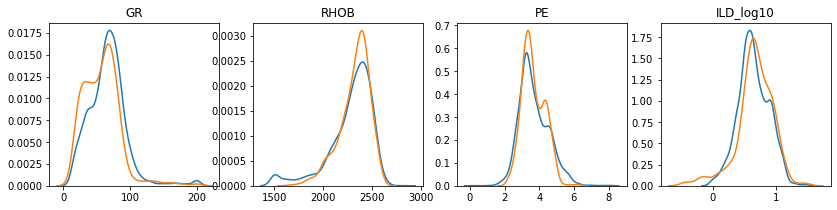

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(14,3))

for ax, feature, *datasets in zip(axs, features, X_train.T, X_test.T):
    for dataset in datasets:
        sns.kdeplot(dataset, ax=ax)
    ax.set_ylabel(None)
    ax.set_title(feature)

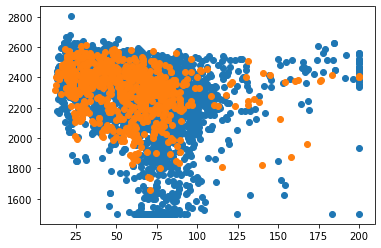

In [8]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(X_test[:,0], X_test[:,1])

## Scale

Some methods don't care about the scale of the features. For example, decision trees and random forests treat each feature independently.

However, most methods &mdash; for example those relying on distance (e.g. KNN), or on linear combinations (e.g. linear regression), or on squeezing functions (e.g. neural nets) &mdash; require the data to be normalized or standardized:

- **Normalization**: scaling to a range of [0, 1] or [-1, +1] for example. As a rule of thumb, you might do this for uniformly distributed data.
- **Standardization**: scaling to a zero mean and unit variance (also known as Z-score). Do this for normally (Gaussian) distributed data.

It's likely a good idea to scale it no matter which method you try.

`scikit-learn` has lots of scalers. The `StandardScaler` removes the mean and scales the data to unit variance.

In [223]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_scaled = scaler.transform(X_train)

**Note that we're not actually going to scale the data at this point. We just want to see what the scaled data will look like.**

Now let's plot the data using equal axes:

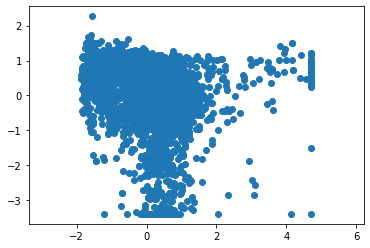

In [10]:
plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.axis('equal')
plt.show()

### Fit the scaler to `train`

It's imperative to fit the scaler (i.e. for the standardizer, to set the mean and standard deviation) on the **training** data only. It must not 'know' about the mean or range of the data you'll use to evaluate the model. 

### Should you scale the target?

There is usually no advantage to scaling the target, but it can make a difference to neural networks. Very large magnitudes may result in 'exploding gradients', which in turn may result in 'saturation' (for some activation functions), or in very large updates to the parameters. Either way, the network will struggle to learn. So in these cases, we will sometimes scale a regression target for a neural network.

----

We're ready to apply a neural network!

In [11]:
import sklearn

print(sklearn.__version__)

# Make sure we can see all of the model details.
sklearn.set_config(print_changed_only=False)

0.24.2


## Scikit-learn's `MLPClassifier`

A **multi-layer perceptron** is a plain, 'vanilla', feed-forward, artificial neural network.

Scikit-learn is a 'shallow' machine learning, but it does have an MLP implementation. So it's a good place to get used to some of the hyperparameters of deep learning, without having to worry about too much of the code required to train a neural network. 

In [12]:
from sklearn.neural_network import MLPClassifier

MLPClassifier()

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### EXERCISE

- Build a neural network with 2 hidden layers, with sizes 24 and 24 respectively. Leave the other hyperparameters as their defaults.
- Why do you get a warning? How can you make it go away?
- Which activation function seems to work best out of ReLU, logistic, and tanh?
- What happens if you reduce `learning_rate_init` to 1e-6, or increase it to 1e6? Why?

In [13]:
# YOUR CODE HERE



In [14]:
# Build this up from one example to the loop.
# NB Can't really use early_stopping b/c introduces another split.
# Increase `max_iter` and/or `tol` to make the NN (appear to) converge.
# A lot of the variance is random (different results for different seeds).
# Small lr: learns nothing quickly, large lr: same as DummyClassifier, essentially
import numpy as np
np.set_printoptions(precision=3)

from sklearn.model_selection import cross_validate 
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline


for act in ['relu', 'logistic', 'tanh']:
    scaler = StandardScaler()
    mlp = MLPClassifier(hidden_layer_sizes=[24, 24],
                        activation=act,
                        max_iter=600,
                        learning_rate_init=1e-3,
                        tol=75e-4,
                        random_state=42
                       )
    model = make_pipeline(scaler, mlp)

    cv_results = cross_validate(model, X_train, y_train,
                                cv=LeaveOneGroupOut(),
                                groups=wells,
                                n_jobs=7,
                               )

    print(f'{act:>10s}', s := cv_results['test_score'], f'mean: {np.mean(s):.3f}', f'std: {np.std(s):.3f}')

      relu [0.628 0.556 0.692 0.65  0.687 0.623 0.692] mean: 0.647 std: 0.046
  logistic [0.524 0.431 0.64  0.505 0.631 0.516 0.631] mean: 0.554 std: 0.075
      tanh [0.615 0.536 0.688 0.639 0.639 0.596 0.667] mean: 0.626 std: 0.046


For comparison, here's how a support vector machine does on this dataset:

    array([0.618, 0.45 , 0.711, 0.661, 0.677, 0.629, 0.688])
    
The mean of those scores is 0.633.

We'd often like to see a prediction. Since we're using cross validation, we have to ask `sklearn` to generate this from the cross-val process, taking a prediction when each well in turn is the validation well.

In [297]:
from sklearn.model_selection import cross_val_predict

scaler = StandardScaler()
mlp = MLPClassifier(hidden_layer_sizes=[24, 24],
                    activation=act,
                    max_iter=600,
                    learning_rate_init=1e-3,
                    tol=75e-4,
                    random_state=42
                   )
model = make_pipeline(scaler, mlp)

y_pred = cross_val_predict(model, X_train, y_train,
                           cv=LeaveOneGroupOut(),
                           groups=wells,
                           n_jobs=7,
                          )

A lot of the code you'll write for machine learning will be wrangling inputs and outputs. 

To make a nice display here, we will need numbers and colours, not strings. So let's make a transformer to turn the predictions into numbers, and associate a colour with each.

I'm going to make my own, subclassing `LabelEncoder`, because I want it to preserve the order of the classes my colour dictionary. (The build-in method uses `np.unique`, which sorts the classes into alphabetical order.)

In [298]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class OrderedEncoder(LabelEncoder):
    def fit(self, y):
        """
        Like the LabelEncoder, but preserves the order
        in the label vector.
        """
        y = column_or_1d(y, warn=True)
        
        # classes_ must be an array for the inverse transform.
        self.classes_ = np.array(list(dict.fromkeys(y)))
        return self

legend = {
    'sandstone': '#F4D03F',
    'siltstone': '#F3E8BF' ,
    'mudstone': '#C1C1C1',
    'wackestone': '#728393',
    'limestone': '#2E86C1',
    'dolomite': '#C186C1'
}

enc = OrderedEncoder()

enc.fit(list(legend))

y_train_int = enc.transform(y_train)
y_pred_int = enc.transform(y_pred)

And a pretty ribbon plot to look at the results in a fairly geological way.

Plotting a 1D array as a ribbon image is not difficult, once we reshape into a 'column' vector (a greyscale image of width 1, basically). We'll use a function from `mlutils` that makes the whole thing a bit easier.

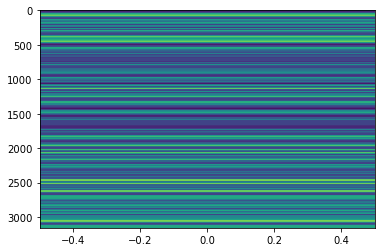

In [299]:
plt.imshow(y_pred_int.reshape(-1, 1), aspect='auto')

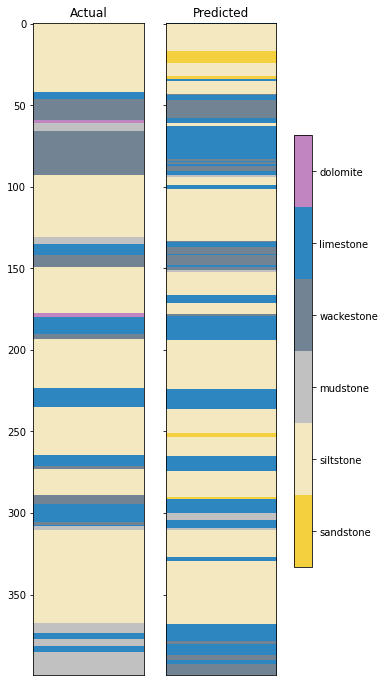

In [300]:
from mlutils import plot_ribbons

plot_ribbons(y_train_int, y_pred_int, s=(None, 400), legend=legend)

If you handle a lot of this kind of data, check out [`striplog`](https://code.agilescientific.com/striplog/). You can do things like filtering based on bed thickness, and make prettier plots.

## A PyTorch classifier

`sklearn` is convenient, but it's impossible to do some things in there. For example, there are only 3 activation functions (not including the identity function), and you cannot apply dropout or skip connections. There's also no way to do convolutions or other types of multi-dimensional operation.

On the other hand, you can do anything you like with PyTorch. So let's see how a network might look in there.

In [301]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [302]:
X_train_pt = torch.tensor(X_scaled, dtype=torch.float32).to(device) 
y_train_pt = torch.tensor(y_train_int, dtype=torch.long).to(device)  # Integers.

traindata = torch.utils.data.TensorDataset(X_train_pt, y_train_pt)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=200, shuffle=True)

You'll often see people using this low-level approach to constructing a network. It gives you fine-tuned control over everything:

In [231]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 100)  # Applies z = Wx + b.
        self.output = nn.Linear(100, 6)
        self.prob = nn.Softmax(dim=-1)

        # Optional.
        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        z1 = self.hidden(x)
        a1 = torch.nn.functional.relu(z1)
        z2 = self.output(a1)
        p2 = self.prob(z2)
        return p2
    
net = Net().to(device)

### EXERCISE

Adapt the network above to build the same network we built with `sklearn` earlier. You need to change the size of the hidden layer, and add another hidden layer of the same size.

There is also a high-level approach to building networks in PyTorch. For example, here's a small network that you might use for regression, with one hidden layer. 

```python
net = nn.Sequential(
      nn.Linear(3, 4),  # 3 inputs, with 4 units in the hidden layer.
      nn.ELU(),         # Use classes instead of nn.functional.
      nn.Linear(4, 1),  # 1 single output...
      nn.Sigmoid()      # ...with logistic function applied.
).to(device)
```

Can you write one that implements the network you made above (but without the optional custom initialization code)?

In [232]:
# YOUR CODE HERE



In [321]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 24)  # Applies z = Wx + b.
        self.hidden2 = nn.Linear(24, 24)
        self.output = nn.Linear(24, 6)
        self.prob = nn.Softmax(dim=-1)

        # Optional.
        nn.init.xavier_uniform_(self.hidden1.weight)
        nn.init.zeros_(self.hidden1.bias)
        nn.init.xavier_uniform_(self.hidden2.weight)
        nn.init.zeros_(self.hidden2.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        z1 = self.hidden1(x)
        a1 = torch.nn.functional.relu(z1)
        z2 = self.hidden2(a1)
        a2 = torch.nn.functional.relu(z2)
        z3 = self.output(a2)
        p3 = self.prob(z3)
        return p3
    
net = Net().to(device)

In [328]:
net = nn.Sequential(
    nn.Linear(4, 24),
    nn.ReLU(), 
    nn.Linear(24, 24),
    nn.ReLU(), 
    nn.Linear(24, 6),
    nn.Softmax(dim=-1),
).to(device)

Training the network:

In [329]:
lr = 0.01
weight_decay = 0.01  # L2 regularization
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

net.train()

epochs = 500
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    for xi, yi in trainloader:
        optimizer.zero_grad()
        y_hat = net(xi)
        loss_ = criterion(y_hat, yi)
        loss_.backward()
        optimizer.step()
        epoch_loss += loss_.item()
    if epoch % 50 == 0:
        print(f"# {epoch}  Loss {epoch_loss}")
print('Finished training')

# 50  Loss 26.38978350162506
# 100  Loss 25.390490412712097
# 150  Loss 25.128445506095886
# 200  Loss 24.95304763317108
# 250  Loss 24.810064435005188
# 300  Loss 24.696680903434753
# 350  Loss 24.606311202049255
# 400  Loss 24.51803410053253
# 450  Loss 24.43516170978546
# 500  Loss 24.355706214904785
Finished training


Now we need to get predictions out of this thing.

In [330]:
net(xi)

tensor([[2.9589e-02, 6.7342e-01, 4.9146e-02, 7.7439e-02, 1.4005e-01, 3.0361e-02],
        [4.1099e-03, 9.4919e-01, 7.6150e-03, 1.2848e-02, 2.2200e-02, 4.0406e-03],
        [5.3350e-03, 9.3576e-01, 9.3633e-03, 1.5926e-02, 2.8454e-02, 5.1613e-03],
        [2.2698e-02, 7.4002e-01, 3.8861e-02, 6.2186e-02, 1.1330e-01, 2.2933e-02],
        [8.8249e-04, 9.8802e-01, 1.7834e-03, 3.1641e-03, 5.3092e-03, 8.4331e-04],
        [7.7459e-02, 2.1902e-01, 1.1310e-01, 1.7008e-01, 3.4166e-01, 7.8684e-02],
        [1.1782e-04, 9.9819e-01, 2.6728e-04, 5.0721e-04, 8.1203e-04, 1.0915e-04],
        [3.0236e-02, 6.5720e-01, 5.0631e-02, 8.0648e-02, 1.5089e-01, 3.0398e-02],
        [8.3329e-02, 1.5080e-01, 1.2296e-01, 1.8532e-01, 3.7019e-01, 8.7404e-02],
        [3.6442e-05, 9.9941e-01, 7.8957e-05, 1.6371e-04, 2.7612e-04, 3.0860e-05],
        [8.3820e-02, 1.5114e-01, 1.2347e-01, 1.8516e-01, 3.6834e-01, 8.8058e-02],
        [1.6826e-03, 9.7790e-01, 3.2989e-03, 5.7319e-03, 9.7590e-03, 1.6248e-03],
        [3.6429e

In [331]:
# Build this up slowly.
net.eval()

evalloader = torch.utils.data.DataLoader(traindata, shuffle=False)

with torch.no_grad():
    y_pred_torch = np.hstack([np.argmax(net(xi).to('cpu'), axis=-1) for xi, yi in evalloader])
    
y_pred_torch.shape

(3157,)

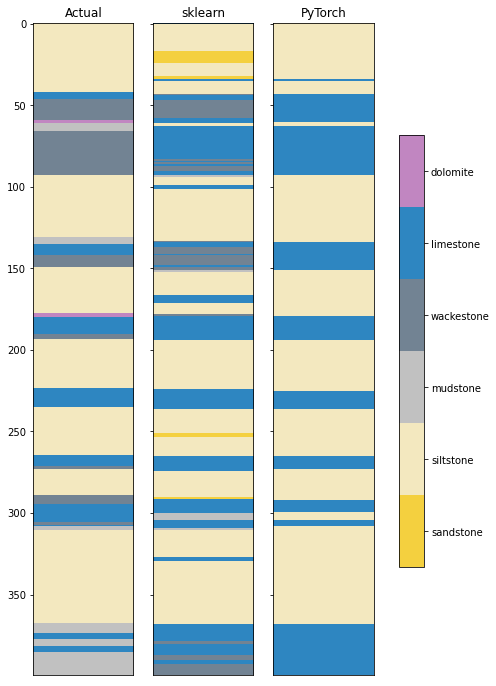

In [332]:
plot_ribbons(y_train_int, y_pred_int, y_pred_torch,
             s=(None, 400), legend=legend,
             titles=['Actual', 'sklearn', 'PyTorch'],
             )

We can inspect the model weights like so:

In [336]:
# For nn.Sequential:
net[0].weight

# For nn.Module:
# net.hidden1.weight

Parameter containing:
tensor([[ 0.2688,  0.0410, -0.3540,  0.0144],
        [ 0.2489, -0.1256, -0.2441, -0.1733],
        [ 0.0462, -0.1207,  0.1758, -0.2240],
        [ 0.1344,  0.1299, -0.0858, -0.1276],
        [-0.1933, -0.1916, -0.0920, -0.2303],
        [ 0.0786, -0.1379, -0.1405,  0.0300],
        [ 0.0832, -0.0425, -0.1021,  0.0233],
        [ 0.2489,  0.0443, -0.3711, -0.0977],
        [ 0.1477, -0.1133, -0.1557, -0.2200],
        [ 0.2415,  0.2034,  0.0241, -0.1122],
        [ 0.2825, -0.0583, -0.2236, -0.1118],
        [ 0.2145, -0.0047, -0.1745, -0.2235],
        [ 0.2868,  0.0553, -0.3702, -0.2610],
        [ 0.2938,  0.0250, -0.3054, -0.2320],
        [-0.2104,  0.1779,  0.1004, -0.0873],
        [-0.0779, -0.0349,  0.3758,  0.1278],
        [-0.1424, -0.2357, -0.0569,  0.0976],
        [ 0.2342, -0.2338, -0.1117,  0.0398],
        [ 0.1772,  0.2039, -0.1524, -0.1012],
        [ 0.0046,  0.1857, -0.1998, -0.0268],
        [-0.2088,  0.2083,  0.3300,  0.1658],
        [ 0.

## PyTorch seems fiddly!

It can be... TensorFlow is just the same. Some people like the control you get in the training loop. Others want something more like `sklearn`. That's where higher-level tools like `skorch` and `fastai` come in (or `keras` for TensorFlow).

[Docs for `skorch`](https://skorch.readthedocs.io/en/latest/index.html)

Let's look at `skorch`...

In [338]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(Net,
                          max_epochs=500,
                          lr=0.01,
                          iterator_train__shuffle=True,
                          )

We can keep things simple by passing in `X_scaled` here, but remember we'll have to use the pipeline containing the scaler eventually.

In [339]:
net.fit(X_scaled.astype(np.float32), y_train_int)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9852       0.2326        1.7936  0.0332
      2        1.8260       0.3497        1.7187  0.0315
      3        1.7223       0.4051        1.6658  0.0331
      4        1.6513       0.4636        1.6245  0.0322
      5        1.5994       0.4778        1.5897  0.0321
      6        1.5583       0.4794        1.5590  0.0324
      7        1.5242       0.4968        1.5313  0.0321
      8        1.4952       0.5174        1.5061  0.0327
      9        1.4701       0.5396        1.4831  0.0336
     10        1.4476       0.5538        1.4617  0.0350
     11        1.4273       0.5649        1.4419  0.0338
     12        1.4085       0.5775        1.4231  0.0349
     13        1.3910       0.5839        1.4053  0.0320
     14        1.3744       0.6028        1.3883  0.0371
     15        1.3587       0.6171        1.3721  0.0375
     16        1.3438       0.6

    106        0.8999       0.6551        0.9062  0.0315
    107        0.8991       0.6551        0.9053  0.0326
    108        0.8984       0.6535        0.9039  0.0317
    109        0.8975       0.6535        0.9030  0.0317
    110        0.8966       0.6535        0.9016  0.0316
    111        0.8958       0.6535        0.9005  0.0318
    112        0.8952       0.6535        0.8994  0.0321
    113        0.8944       0.6535        0.8987  0.0324
    114        0.8937       0.6535        0.8976  0.0318
    115        0.8928       0.6551        0.8968  0.0324
    116        0.8922       0.6566        0.8958  0.0321
    117        0.8914       0.6566        0.8952  0.0315
    118        0.8907       0.6582        0.8944  0.0315
    119        0.8900       0.6614        0.8940  0.0331
    120        0.8894       0.6614        0.8931  0.0328
    121        0.8886       0.6614        0.8925  0.0324
    122        0.8879       0.6614        0.8921  0.0343
    123        0.8873       0.6

    217        0.8515       0.6677        0.8535  0.0328
    218        0.8513       0.6693        0.8533  0.0329
    219        0.8510       0.6693        0.8533  0.0340
    220        0.8508       0.6709        0.8535  0.0326
    221        0.8505       0.6693        0.8529  0.0317
    222        0.8503       0.6693        0.8528  0.0333
    223        0.8501       0.6741        0.8524  0.0339
    224        0.8499       0.6709        0.8522  0.0354
    225        0.8497       0.6693        0.8521  0.0355
    226        0.8495       0.6725        0.8518  0.0342
    227        0.8492       0.6709        0.8523  0.0325
    228        0.8490       0.6677        0.8521  0.0317
    229        0.8489       0.6693        0.8516  0.0322
    230        0.8487       0.6725        0.8516  0.0323
    231        0.8484       0.6693        0.8511  0.0323
    232        0.8484       0.6709        0.8515  0.0322
    233        0.8479       0.6725        0.8517  0.0320
    234        0.8479       0.6

    336        0.8319       0.6772        0.8403  0.0324
    337        0.8319       0.6804        0.8412  0.0322
    338        0.8316       0.6788        0.8405  0.0328
    339        0.8316       0.6804        0.8408  0.0328
    340        0.8314       0.6804        0.8407  0.0351
    341        0.8312       0.6804        0.8411  0.0332
    342        0.8311       0.6804        0.8405  0.0335
    343        0.8309       0.6820        0.8403  0.0331
    344        0.8309       0.6788        0.8401  0.0331
    345        0.8307       0.6804        0.8398  0.0314
    346        0.8306       0.6804        0.8400  0.0358
    347        0.8306       0.6804        0.8393  0.0328
    348        0.8305       0.6804        0.8392  0.0362
    349        0.8303       0.6804        0.8396  0.0382
    350        0.8302       0.6788        0.8396  0.0380
    351        0.8301       0.6804        0.8396  0.0369
    352        0.8301       0.6820        0.8397  0.0376
    353        0.8297       0.6

    460        0.8183       0.6804        0.8368  0.0341
    461        0.8184       0.6804        0.8363  0.0434
    462        0.8181       0.6804        0.8363  0.0427
    463        0.8179       0.6804        0.8367  0.0384
    464        0.8179       0.6772        0.8373  0.0359
    465        0.8179       0.6788        0.8371  0.0345
    466        0.8179       0.6804        0.8364  0.0346
    467        0.8177       0.6788        0.8356  0.0344
    468        0.8176       0.6788        0.8369  0.0344
    469        0.8174       0.6788        0.8362  0.0345
    470        0.8174       0.6804        0.8368  0.0358
    471        0.8173       0.6788        0.8369  0.0328
    472        0.8171       0.6788        0.8364  0.0322
    473        0.8172       0.6788        0.8367  0.0330
    474        0.8169       0.6788        0.8369  0.0334
    475        0.8169       0.6788        0.8364  0.0321
    476        0.8168       0.6788        0.8364  0.0333
    477        0.8165       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (hidden1): Linear(in_features=4, out_features=24, bias=True)
    (hidden2): Linear(in_features=24, out_features=24, bias=True)
    (output): Linear(in_features=24, out_features=6, bias=True)
    (prob): Softmax(dim=-1)
  ),
)

Notice this gives us a validation score. That's the default 20% split... it's convenient for some tasks. Even better, this `skorch` model retains its history:

In [243]:
net.history

[{'batches': [{'train_loss': 2.001585006713867, 'train_batch_size': 128},
   {'train_loss': 1.9542683362960815, 'train_batch_size': 128},
   {'train_loss': 1.9810534715652466, 'train_batch_size': 128},
   {'train_loss': 2.00888991355896, 'train_batch_size': 128},
   {'train_loss': 1.9247891902923584, 'train_batch_size': 128},
   {'train_loss': 2.0059194564819336, 'train_batch_size': 128},
   {'train_loss': 1.8865495920181274, 'train_batch_size': 128},
   {'train_loss': 1.8595482110977173, 'train_batch_size': 128},
   {'train_loss': 1.8743704557418823, 'train_batch_size': 128},
   {'train_loss': 1.8899309635162354, 'train_batch_size': 128},
   {'train_loss': 1.869005799293518, 'train_batch_size': 128},
   {'train_loss': 1.9285705089569092, 'train_batch_size': 128},
   {'train_loss': 1.8344303369522095, 'train_batch_size': 128},
   {'train_loss': 1.8156683444976807, 'train_batch_size': 128},
   {'train_loss': 1.8761073350906372, 'train_batch_size': 128},
   {'train_loss': 1.8252816200256

### EXERCISE

Can you get the `train_loss` and `valid_loss` data and plot them each against eopch number?

In [244]:
# YOUR CODE HERE



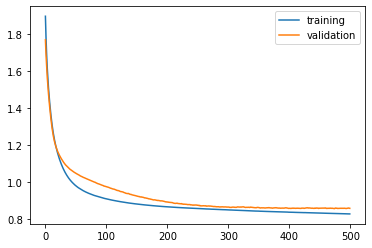

In [245]:
trains = [epoch['train_loss'] for epoch in net.history]
vals = [epoch['valid_loss'] for epoch in net.history]

plt.plot(trains, label='training')
plt.plot(vals, label='validation')
plt.legend()

**But we don't want the train/val split &mdash; remember, it's cheating! We'd like to use cross-validation.**

That would be fiddly to implement in the convenient way `sklearn` gives us, so let's use `skorch`, a scikit-learn-like interface for PyTorch.

`skorch.NeuralNetClassifier` takes an instance of `nn.Module` or `nn.Sequential` and creats a `sklearn`-like model from it, with `.fit()` and `.predict()` methods, etc. This makes it compatible with `sklearn` pipelines, cross validation, and model-tuning workflows. Awesome!

Normally, it reserves 20% of the incoming data for validation; we can turn that off, since we're doing it ourselves. Also, we don't need the PyTorch `DataLoader` contrivance; we can just pass in NumPy arrays (of the correct type).

In [337]:
net = NeuralNetClassifier(Net,
                          max_epochs=300,
                          lr=0.01,
                          iterator_train__shuffle=True,
                          train_split=None,  # Turn off internal validation.
                          verbose=0,  # We're not that interested in this now.
                          )

pipe = make_pipeline(scaler, net)

In [247]:
cv_scores = cross_validate(pipe,
                           X_train.astype(np.float32),
                           y_train_int,
                           cv=LeaveOneGroupOut(), groups=wells,
                           scoring='f1_weighted',
                           return_train_score=True,
                           )

We can still get at the history in `net`, but we don't really care about it any more. Instead, we can inspect the scores across our wells (groups):

In [248]:
cv_scores

{'fit_time': array([8.251, 7.833, 8.171, 8.118, 8.113, 8.168, 9.057]),
 'score_time': array([0.005, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005]),
 'test_score': array([0.57 , 0.376, 0.723, 0.614, 0.643, 0.611, 0.654]),
 'train_score': array([0.69 , 0.67 , 0.673, 0.683, 0.675, 0.675, 0.671])}

As usual, to get meaningful predictions from CV, we have to use `cross_val_predict`:

In [249]:
y_pred_skorch = cross_val_predict(pipe,
                                  X_train.astype(np.float32),
                                  y_train_int,
                                  cv=LeaveOneGroupOut(), groups=wells,
                                  )

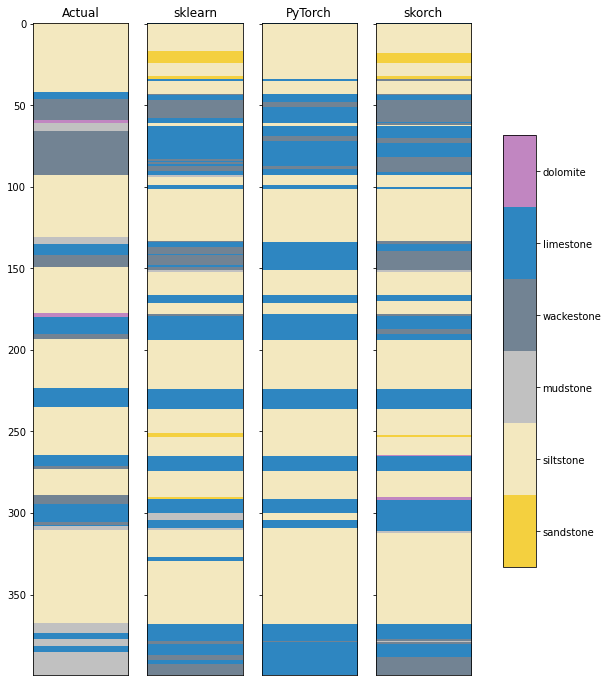

In [250]:
plot_ribbons(y_train_int, y_pred_int, y_pred_torch, y_pred_skorch,
             s=(None, 400), legend=legend,
             titles=['Actual', 'sklearn', 'PyTorch', 'skorch'],
             )

## Weights

If you should ever want to inspect the weights of the model, they are available to you like so:

In [354]:
net.module_.hidden1.weight

Parameter containing:
tensor([[-0.5517, -0.1706,  0.5781, -0.4244],
        [ 0.4452, -0.1651, -0.3340,  0.1113],
        [-0.2070,  0.2195,  0.1867,  0.5311],
        [ 0.2724,  0.1385,  0.7042,  0.3606],
        [-1.2366, -0.3033, -0.1384,  0.2509],
        [-0.1179,  0.1077, -0.4162,  0.0977],
        [-0.0770, -0.6034,  0.1735,  0.1073],
        [ 0.2305, -0.5439,  0.0998, -0.3236],
        [-0.4046,  0.0931, -0.2621,  0.2094],
        [-0.1174, -0.1802,  0.7356, -0.3287],
        [ 0.7053, -0.3269,  0.1511,  0.4449],
        [-0.1402, -0.4966, -0.5084, -0.2327],
        [-0.1625,  0.2267, -0.2000, -0.3757],
        [-0.1079, -0.2097, -0.7688,  0.3261],
        [-0.3864,  0.5731, -0.3738, -0.4946],
        [ 0.7711,  0.0581,  0.1649, -0.0715],
        [-0.3838, -0.1363, -0.3528, -0.3852],
        [-0.2858, -0.2988, -0.3164, -0.4054],
        [-0.4533,  0.1630, -0.3043,  0.0593],
        [ 0.0327,  0.3388, -0.4958, -0.3503],
        [-0.7918, -0.0778,  0.1606,  0.4435],
        [ 0.

## Testing

Eventually, you will want to test your model against the holdout `test` data. This means:

- Train the model on all the training data.
- Check how it does on `X_test`.

In [252]:
net = NeuralNetClassifier(Net,
                          max_epochs=500,
                          lr=0.01,
                          iterator_train__shuffle=True,
                          train_split=None,  # Turn off internal validation.
                          verbose=0,
                          )

pipe = make_pipeline(scaler, net)

pipe.fit(X_train.astype(np.float32), y_train_int)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (hidden1): Linear(in_features=4, out_features=24, bias=True)
    (hidden2): Linear(in_features=24, out_features=24, bias=True)
    (output): Linear(in_features=24, out_features=6, bias=True)
    (prob): Softmax(dim=-1)
  ),
))],
         verbose=False)

In [267]:
y_pred_int = pipe.predict(X_test.astype(np.float32))

In [268]:
from sklearn.metrics import plot_confusion_matrix, classification_report

y_pred = enc.inverse_transform(y_pred_int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    dolomite       0.79      0.29      0.43        92
   limestone       0.52      0.71      0.60       146
    mudstone       0.71      0.32      0.44       142
   sandstone       0.12      0.17      0.14        23
   siltstone       0.67      0.92      0.78       240
  wackestone       0.55      0.51      0.53       166

    accuracy                           0.60       809
   macro avg       0.56      0.49      0.48       809
weighted avg       0.62      0.60      0.58       809



## Final training

Finally, if this is **the** model, you'll need to train it on all your data.

In [355]:
net = NeuralNetClassifier(Net,
                          max_epochs=500,
                          lr=0.01,
                          iterator_train__shuffle=True,
                          train_split=None,  # Turn off internal validation.
                          verbose=0,
                          )

pipe = make_pipeline(scaler, net)

y_int = enc.transform(y)

pipe.fit(X.astype(np.float32), y_int)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (hidden1): Linear(in_features=4, out_features=24, bias=True)
    (hidden2): Linear(in_features=24, out_features=24, bias=True)
    (output): Linear(in_features=24, out_features=6, bias=True)
    (prob): Softmax(dim=-1)
  ),
))],
         verbose=False)

There's no checking to do on this model &mdash; we don't have any data to validate against. But we think it's the best model we can make.

## Persistence

Once you find and tune a model you like, you can [save](https://skorch.readthedocs.io/en/latest/user/save_load.html) its parameters. The easiest way to do this is the same as for `sklearn` models: with pickle.

In [272]:
import joblib

joblib.dump(pipe, 'facies_pipeline.pkl')

['facies_pipeline.pkl']

In [273]:
model = joblib.load('facies_pipeline.pkl')

model

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (hidden1): Linear(in_features=4, out_features=24, bias=True)
    (hidden2): Linear(in_features=24, out_features=24, bias=True)
    (output): Linear(in_features=24, out_features=6, bias=True)
    (prob): Softmax(dim=-1)
  ),
))],
         verbose=False)

There are a lot of other ways to save the model, however, and still other ways to save the parameter dictionary (for example). Check the `skorch` and/or `PyTorch` docs.

---
&copy; 2022 Agile Scientific, CC BY